# Physics-Informed Neural Networks (PINNs) in JAX

In [2]:
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
from flax import nnx
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # progress bar
import logging

#### Auxiliary functions

In [3]:
@nnx.jit
def train_step(model, optimizer, x):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    optimizer.update(grads)
    return loss

def _train_epoch(
    model, optimizer, xs_train, batch_size, rng
):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm]
        loss = train_step(model, optimizer, batch_xs)
        epoch_loss.append(loss)  # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    return model, train_loss


def train(model, optimizer, xs_train, 
          batch_size,epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss = _train_epoch(
            model, optimizer, xs_train, 
            batch_size, random.key(1),
        )

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

In [4]:
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score

In [5]:
class MLPRegressor(BaseEstimator):

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10, show_progress=True):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch
        self.show_progress = show_progress

    def fit(self, X, y=None):
        self._optimizer = nnx.ModelAndOptimizer(self.model, optax.adam(self.lr))

        self.train_loss_history = train(self.model, self._optimizer, X, self.batch_size, self.epochs, self.log_period_epoch, self.show_progress)

        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        return jax.vmap(self.model)(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)    

## Exercise: Burgers' equation

We consider the following viscous Burgers equation:
\begin{align}
  &u_t + uu_x -\nu u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}
where $\nu=0.025$ is the viscosity parameter.

We take the following steps to build a PINN model:
1. Define the domain
2. Define the initial/boundary conditions (IC/BC) and the training points
3. Define PDE residuals and loss term for the PDE
4. Define PINNs architecture
5. Training

In [6]:
# Discretization of the domain (mesh)
nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Viscosity
nu = 0.025

- Define the IC/BC and training points

In [7]:
# Define the IC
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(np.pi*X_init[:, 0:1])

# Define the BC
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1))

# Define training collocation points
num_collocation_points = 2000
idx_Xf = np.random.choice(X_star.shape[0], num_collocation_points, replace=False)
X_colloc_train = X_star[idx_Xf]

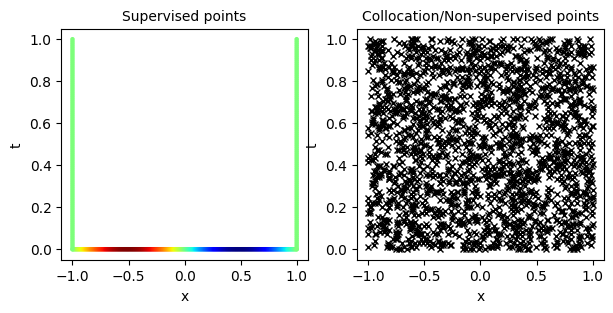

In [8]:
# Plot of the training (supervised) and the collocation (non-supervised) points
X_supervised = np.concatenate((X_init, X_bc), axis=0)
u_supervised = np.concatenate((u_init, u_bc), axis=0)

fig = plt.figure(figsize=[7,3])
axes = fig.subplots(1,2, sharex=False, sharey=False)
img1 = axes[0].scatter(X_supervised[:, 0:1], X_supervised[:, 1:2], c=u_supervised, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Supervised points', fontsize=10)
axes[0].set_xlabel('x', fontsize=10)
axes[0].set_ylabel('t', fontsize=10)
img2 = axes[1].plot(X_colloc_train[:, 0], X_colloc_train[:, 1], 'x', markersize=5, color='black')
axes[1].set_title('Collocation/Non-supervised points', fontsize=10)
axes[1].set_xlabel('x', fontsize=10)
axes[1].set_ylabel('t', fontsize=10)
plt.show()

- Define the model

In [ ]:
class Model(nnx.Module):
  def __init__(self, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(2, 20, rngs=rngs)
    self.linear2 = nnx.Linear(20, 20, rngs=rngs)
    self.linear3 = nnx.Linear(20, 20, rngs=rngs)
    self.linear4 = nnx.Linear(20, 1, rngs=rngs)

  def __call__(self, x):
    y = self.linear1(x)
    y = nnx.tanh(y)
    y = self.linear2(y)
    y = nnx.tanh(y)
    y = self.linear3(y)
    y = nnx.tanh(y)
    y = self.linear4(y)
    return y.squeeze()

- Implement the calculation of the PDE residual

In [ ]:
def pde_residual(model, x):
    grad_x = lambda x: jax.grad(model)(x)[0]
    grad_t = lambda x: jax.grad(model)(x)[1]
    u_x = grad_x(x)
    u_t = grad_t(x)
    u_xx = jax.grad(grad_x)(x)[0]
    u = model(x)
    f = u_t + u*u_x - nu*u_xx

    return f

- Define the loss function

In [ ]:
@nnx.jit
def loss_fn(model, x):
    pde_residual_at_collocation_points = jax.vmap(pde_residual, in_axes=(None, 0))(model, x)
    pde_loss_contribution = jnp.mean(jnp.square(pde_residual_at_collocation_points))

    bc_residual = model(X_bc)
    bc_residual_contribution = jnp.mean(jnp.square(bc_residual))

    init_residual = model(X_init) + jnp.sin(jnp.pi*X_init[:,0])
    init_residual_contribution = jnp.mean(jnp.square(init_residual))

    total_loss = pde_loss_contribution + bc_residual_contribution + init_residual_contribution

    return total_loss

- Create an instance of the PINN and wrap into the `MLPRegressor` class. Train the
  model. NOTE: if you experience issues, you may need to restart the kernel and/or re-evaluate the cells above where the training functions are defined,
  befor running the training.

In [ ]:
pinn = Model(nnx.Rngs(0))
m = MLPRegressor(pinn, 0.001, 5000, 64)
m.fit(X_colloc_train)

- Plot the training curve (history of the training loss)

In [ ]:
plt.plot(m.train_loss_history)
plt.yscale("log")

- Compare the prediction of the trained PINN over all the mesh `X_star` with the
  reference solution.

In [ ]:
# Load reference solution
u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[-1]

In [ ]:
pred = m.predict(X_star)

In [ ]:
# Plot and compare the solutions
fig = plt.figure(figsize=[15,3])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('PINN prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star-pred[:,None], cmap='seismic', vmax=0.01, vmin=-0.01, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])
plt.show()

- Evaluate the R^2 score between the predictions and the reference solution

In [ ]:
m.score(X_star, u_star.ravel())